In [1]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
import pandas as pd
import polars as pl
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
sb.set()

In [3]:
kaggle_steam: pd.DataFrame = catalog.load('kaggle_steam')
kaggle_steam.head()

[04/02/23 05:15:02] INFO     Loading data from 'kaggle_steam' (CSVDataSet)...                   ]8;id=922477;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=793040;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


<Axes: xlabel='median_playtime'>

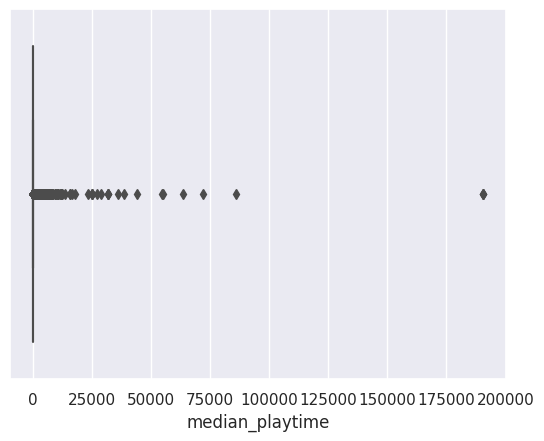

In [4]:
sb.boxplot(data=kaggle_steam, x="median_playtime")

In [5]:
kaggle_steam.shape

(27075, 18)

<Axes: xlabel='median_playtime', ylabel='Count'>

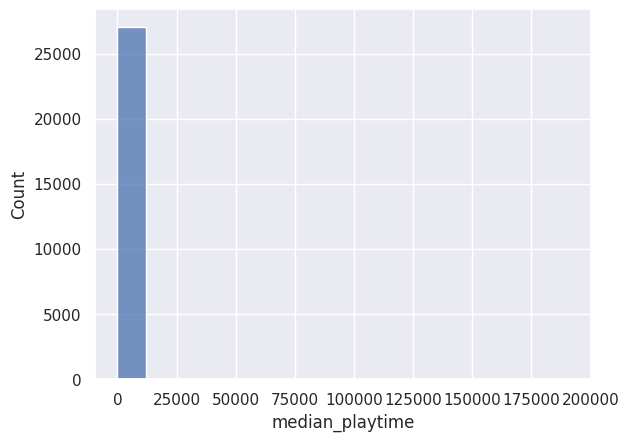

In [6]:
sb.histplot(data=kaggle_steam["median_playtime"])

<Axes: xlabel='median_playtime', ylabel='Count'>

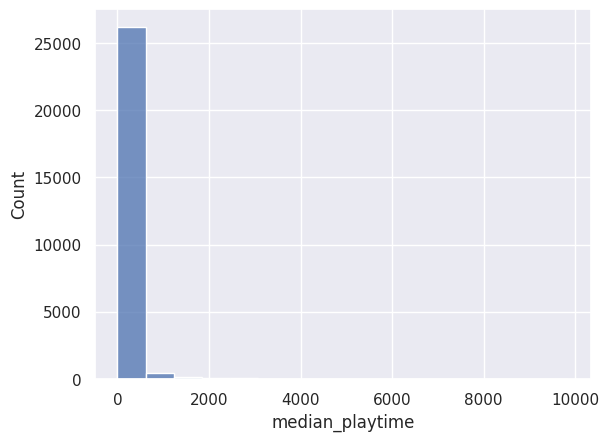

In [7]:
median_playtime = kaggle_steam['median_playtime']
sb.histplot(data=median_playtime.loc[(median_playtime < 10000)])

<Axes: xlabel='median_playtime', ylabel='Count'>

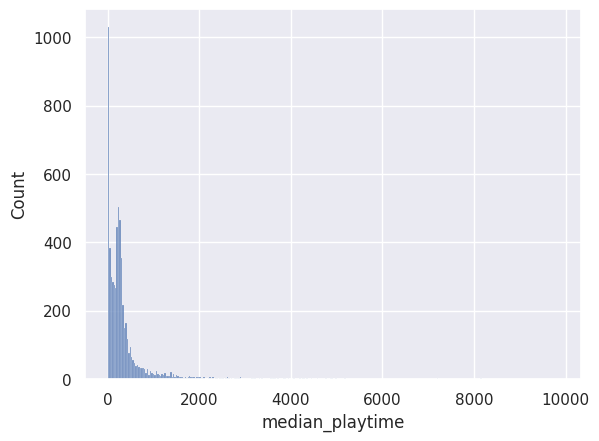

In [8]:
sb.histplot(data=median_playtime.loc[(0 < median_playtime) & (median_playtime < 10000)])

<Axes: >

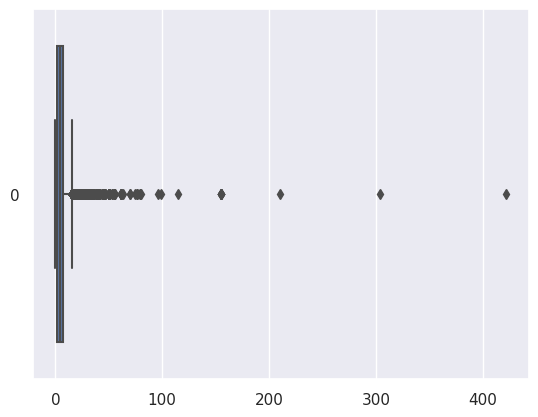

In [9]:
sb.boxplot(data=kaggle_steam['price'], orient='h')

<Axes: xlabel='price', ylabel='Count'>

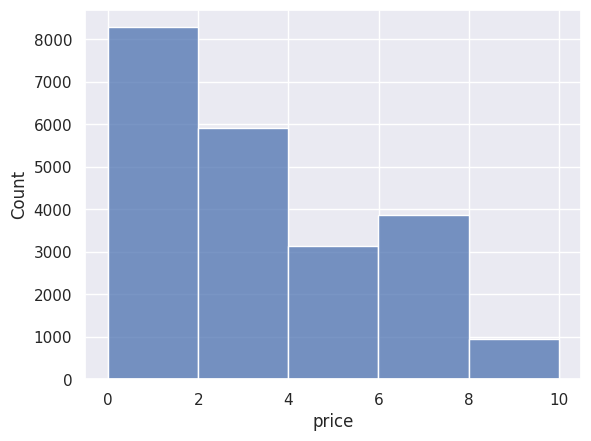

In [10]:
sb.histplot(data=kaggle_steam[kaggle_steam['price'] < 10], x='price', bins=5)

# Categorical variables analysis

The dataset has **11** categorical variables: `appid`, `name`, `release_date`, `english`, `developer`. `publisher`, `platforms`, `categories`, `genres`, `steamspy_tags` and `owners`.

In [11]:
kaggle_steam.dtypes

appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

We will be examining the following categorical variables to see if we can use them for clustering.

- `release_date`
- `english`
- `platforms`
- `categories`
- `genres`
- `steamspy_tags`
- `owners`

We omitted:

- `app_id` as it is id value, it has no meaning,
- `name` is unique per record, hence has no meaning
- `developer` is immediately apparent to have many labels, it will increase dimensionality of our data too much and impact our model's performance
- `publisher` same as above

## Dealing with variables with single class per record

We will first look at `release_date`, `english`, and `owners` as each record can only belong to a single class.

### `release_date`

In [12]:
# Since dates are in YYYY-MM-dd format we can just take advantage of this and split on '-' to get the year.

kaggle_steam['year'] = kaggle_steam['release_date'].str.split('-').map(lambda x: int(x[0]))
kaggle_steam['year'].value_counts()

2018    8160
2017    6357
2016    4361
2015    2597
2019    2213
2014    1555
2013     418
2012     320
2009     305
2011     239
2010     238
2008     145
2007      93
2006      48
2005       6
2004       6
2001       4
2003       3
2000       2
1999       2
2002       1
1998       1
1997       1
Name: year, dtype: int64

#### Observations

We observe that the dataset contains very few games from before 2014. The bulk of the data is from 2014 onwards. Since we have converted this column to numeric, it could be used. It can be true that a game from 1997 is far from 2019 in the sense that times have changed.

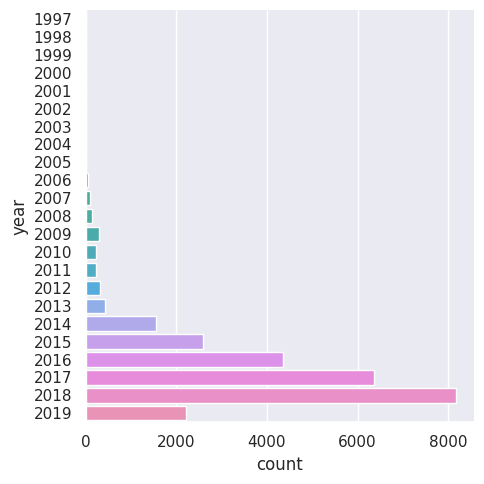

In [13]:
sb.catplot(data=kaggle_steam, y='year', kind='count')

### `english`

It is immediately obvious that `english` is not a very good variable. Over `98%` of the data is `english` and thus it likely has limited effect on clustering.

In [14]:
kaggle_steam['english'].value_counts() / len(kaggle_steam)

1    0.981127
0    0.018873
Name: english, dtype: float64

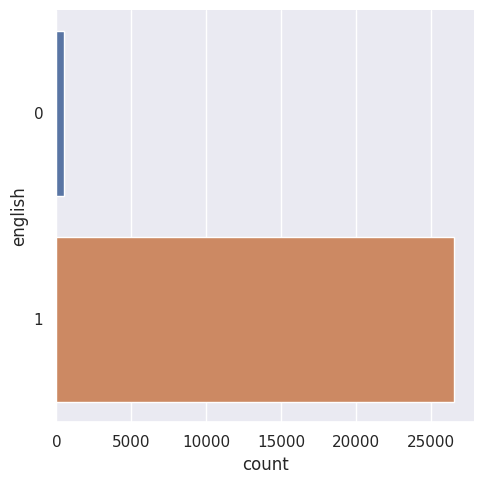

In [15]:
sb.catplot(data=kaggle_steam, y='english', kind='count')

### `owners`

In [16]:
# Take the upper limit as the estimate, then log10
kaggle_steam['est_owners'] = kaggle_steam['owners'].str.split('-').map(lambda x: int(x[1])).map(np.log10)
kaggle_steam['est_owners'].value_counts()

4.30103    18596
4.69897     3059
5.00000     1695
5.30103     1386
5.69897     1272
6.00000      513
6.30103      288
6.69897      193
7.00000       46
7.30103       21
7.69897        3
8.00000        2
8.30103        1
Name: est_owners, dtype: int64

#### Observations

We could take different approach to transforming `owners` to numeric. Either via OrdinalEncoder or another method.

Since the bracket size isn't even, i.e 20000 -> 50000 is 2.5x but 50000 -> 100000 is 2x only, we decided to use the upper limit instead of encoding them as 0..1..2..3 as it is more representative. We also decided to `log10` to reduce the difference between `20,000` and `100,000,000` because a distance that large can throw off the model. Since this is discrete and non-continuous, the violinplot looks funny.

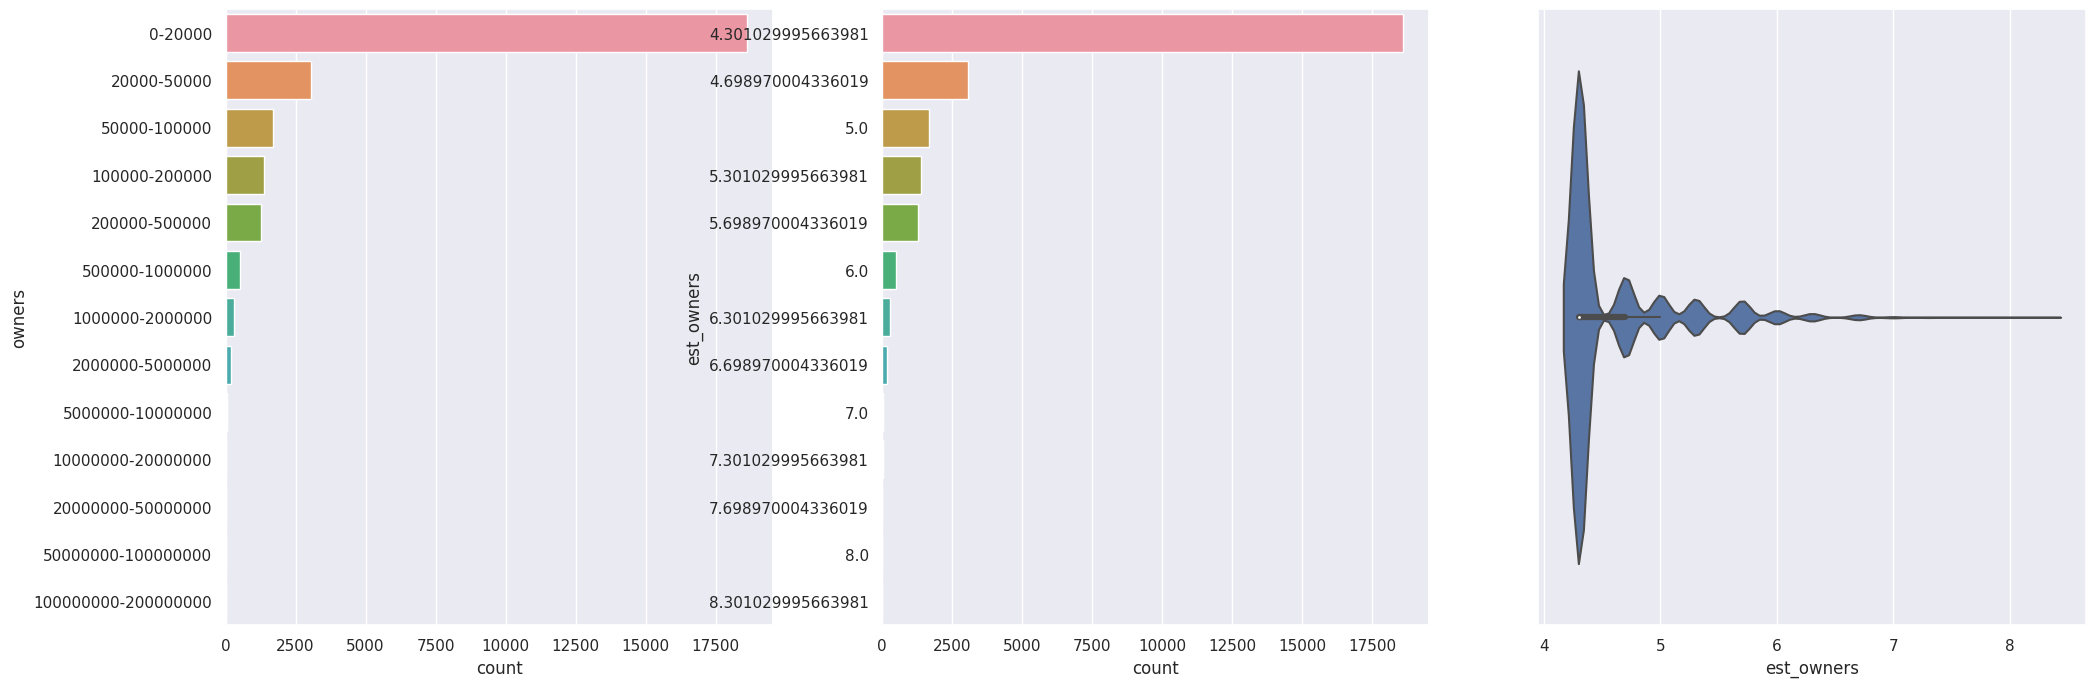

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(24,8))
sb.countplot(data=kaggle_steam, y='owners', order=sorted(kaggle_steam['owners'].unique(), key=lambda x: int(x.split('-')[1])), ax=ax[0])
sb.countplot(data=kaggle_steam, y='est_owners', order=kaggle_steam['est_owners'].unique().sort(), ax=ax[1])
sb.violinplot(data=kaggle_steam, x='est_owners', ax=ax[2])
%matplotlib inline


## Dealing with variables with multiple classes per record

These variables are `platforms`, `categories`, `genres`, `steamspy_tags`, with each class separated by a semicolon (;).

In [18]:
kaggle_steam[['platforms', 'categories', 'genres', 'steamspy_tags']].tail(1)

,platforms,categories,genres,steamspy_tags
27074,windows;mac,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure


In [19]:
def describe_categorical_as_onehot(df: pd.DataFrame, X: pd.Series, keep: "set[str] | 'all'" = None, sep=';'):
  mlb = MultiLabelBinarizer()
  x = mlb.fit_transform(X.str.split(sep)).T
  print(f"Column `{X.name}` has {len(mlb.classes_)} unique labels")
  if keep is not None:
    for i, category in enumerate(mlb.classes_):
      if keep == 'all' or (category in keep):
        df[category] = x[i]
  return mlb.classes_

### `platforms`

In [20]:
describe_categorical_as_onehot(kaggle_steam, kaggle_steam['platforms'], keep={'windows', 'mac', 'linux'})

Column `platforms` has 3 unique labels


array(['linux', 'mac', 'windows'], dtype=object)

In [21]:
kaggle_steam[["platforms", "windows", "mac", "linux"]]

,platforms,windows,mac,linux
0,windows;mac;linux,1,1,1
1,windows;mac;linux,1,1,1
2,windows;mac;linux,1,1,1
3,windows;mac;linux,1,1,1
4,windows;mac;linux,1,1,1
...,...,...,...,...
27070,windows,1,0,0
27071,windows,1,0,0
27072,windows,1,0,0
27073,windows;mac,1,1,0


In [22]:
kaggle_steam[['windows', 'mac', 'linux']].sum() / len(kaggle_steam)

windows    0.999815
mac        0.297913
linux      0.193352
dtype: float64

#### Observations

`99.98%` of all games support windows, it is the most ubiquitous platform, so it is probably not the most useful.

<Axes: ylabel='count'>

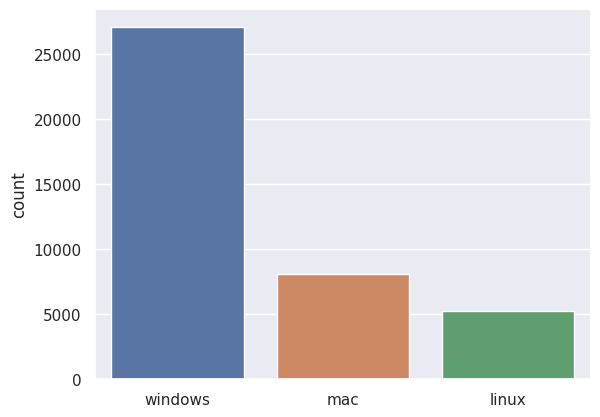

In [23]:
q = kaggle_steam[['windows', 'mac', 'linux']].sum().to_frame(name='count')
sb.barplot(x=q.index, y=q['count'])

### `categories`

We also created a `num_categories` column.

In [24]:
kaggle_steam['num_categories'] = kaggle_steam['categories'].str.split(';').map(len)
kaggle_steam['num_categories']

0        4
1        4
2        2
3        4
4        3
        ..
27070    2
27071    1
27072    7
27073    2
27074    2
Name: num_categories, Length: 27075, dtype: int64

In [25]:
categories_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
describe_categorical_as_onehot(categories_df, kaggle_steam['categories'], keep='all')

Column `categories` has 29 unique labels


array(['Captions available', 'Co-op', 'Commentary available',
       'Cross-Platform Multiplayer', 'Full controller support',
       'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
       'Local Co-op', 'Local Multi-Player', 'MMO', 'Mods',
       'Mods (require HL2)', 'Multi-player', 'Online Co-op',
       'Online Multi-Player', 'Partial Controller Support',
       'Shared/Split Screen', 'Single-player', 'Stats',
       'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards',
       'Steam Trading Cards', 'Steam Turn Notifications',
       'Steam Workshop', 'SteamVR Collectibles', 'VR Support',
       'Valve Anti-Cheat enabled'], dtype=object)

In [26]:
pd.concat([kaggle_steam, categories_df], axis=1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,0,0,0,1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,...,0,1,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,...,0,1,1,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,...,0,0,1,0,0,0,0,0,0,0


In [27]:
categories_df

,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


It is interesting to note that `Single-player` and `Multi-player` are not mutually exclusive.

In [28]:
categories_df[['Single-player', 'Multi-player']]

,Single-player,Multi-player
0,0,1
1,0,1
2,0,1
3,0,1
4,1,1
...,...,...
27070,1,0
27071,1,0
27072,1,1
27073,1,0


In [29]:
(categories_df.sum() / len(categories_df)).sort_values(ascending=False).head(10)

Single-player                 0.948403
Steam Achievements            0.521884
Steam Trading Cards           0.292447
Steam Cloud                   0.266630
Full controller support       0.210342
Partial Controller Support    0.156380
Multi-player                  0.146777
Steam Leaderboards            0.127018
Online Multi-Player           0.091856
Shared/Split Screen           0.079483
dtype: float64

#### Observations

A lot of the labels appear to be associated with one another, for example `Multi-player` and similar labels such as `Co-op`, `Cross-platform Multiplayer`, etc. `Single-player` is also most likely not going to be useful due to `94.8%` of the dataset supporting solo play, so there is little variance.

In [30]:
# pearson's correlation does not work for categorical data. only continuous data.
# sb.heatmap(categories_df.corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f', ax=plt.subplots(1,1,figsize=(24,20))[1], square=True)

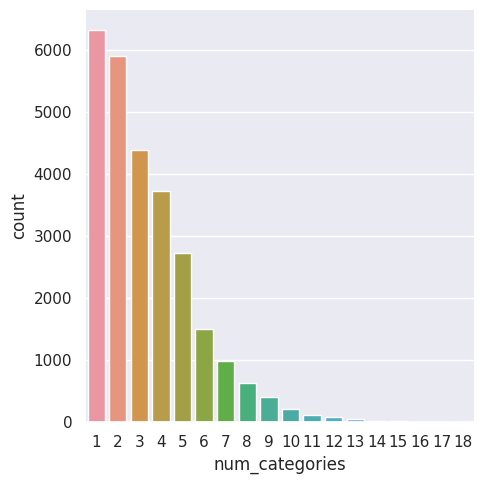

In [31]:
sb.catplot(kaggle_steam, x='num_categories', kind='count')

In [32]:
kaggle_steam['num_categories'].describe()

count    27075.000000
mean         3.313980
std          2.235836
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         18.000000
Name: num_categories, dtype: float64

<Axes: >

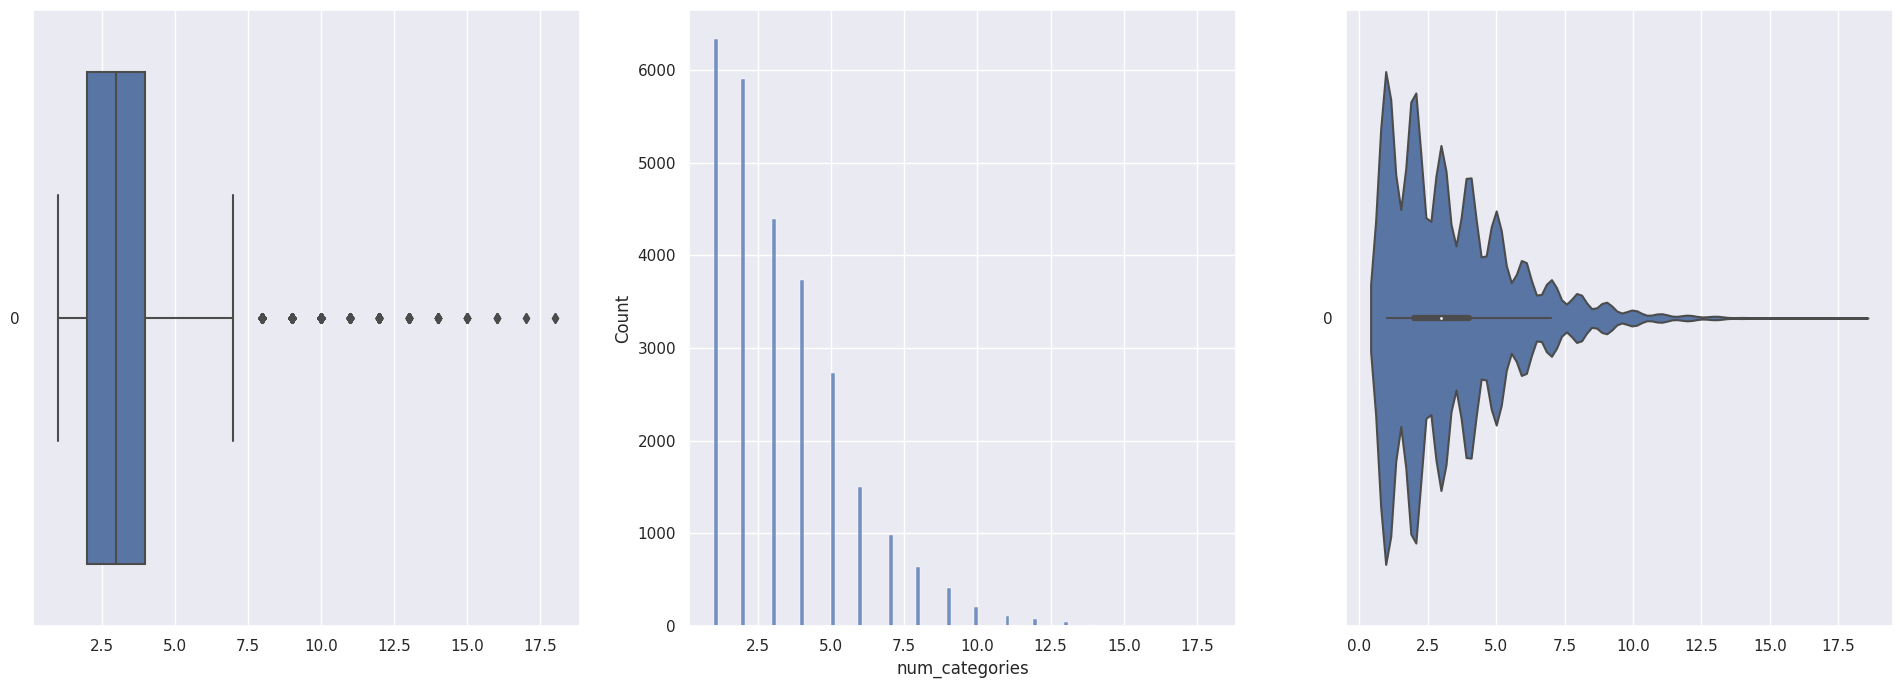

In [33]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
sb.boxplot(data=kaggle_steam['num_categories'], orient='h', ax=ax[0])

sb.histplot(data=kaggle_steam['num_categories'], ax=ax[1])

sb.violinplot(data=kaggle_steam['num_categories'], orient='h', ax=ax[2])

In [34]:
kaggle_steam[kaggle_steam['num_categories'] > 7]['num_categories'].value_counts()

8     634
9     407
10    204
11    111
12     73
13     46
14     14
15     10
16      5
17      2
18      2
Name: num_categories, dtype: int64

In [35]:
kaggle_steam[kaggle_steam['num_categories'] > 15].sort_values(by='est_owners')

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,average_playtime,median_playtime,owners,price,year,est_owners,linux,mac,windows,num_categories
5574,368180,Polyball,2017-12-01,1,Studio Monolith,Studio Monolith,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Casual;Indie;Racing;Simulation,...,0,0,0-20000,10.99,2017,4.30103,1,1,1,17
7410,420900,Mech Anarchy,2016-03-15,1,Trevor Madge,Trevor Madge,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie;Early Access,...,0,0,0-20000,5.79,2016,4.30103,0,0,1,18
8440,451600,CounterAttack,2019-03-11,1,Relative Games,Relative Games,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Indie,...,0,0,0-20000,11.39,2019,4.30103,1,1,1,18
13583,600440,Cyber Complex,2017-08-04,1,PolarityFlow;Adrian Zingg,PolarityFlow,windows;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Casual;Indie;Simulation;Strategy,...,13,13,0-20000,6.99,2017,4.30103,1,0,1,16
2503,273500,Over 9000 Zombies!,2015-02-25,1,Loren Lemcke,Loren Lemcke,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie,...,17,17,100000-200000,1.59,2015,5.30103,0,0,1,16
3651,314970,Age of Conquest IV,2016-04-05,1,Noble Master LLC,Noble Master LLC,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Free to Play;Indie;Strategy,...,93,141,200000-500000,0.00,2016,5.69897,1,1,1,16
4724,346330,BrainBread 2,2016-07-20,1,Reperio Studios,Reperio Studios,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Free to Play;Indie;Early Access,...,46,43,1000000-2000000,0.00,2016,6.30103,1,1,1,17
780,41070,Serious Sam 3: BFE,2011-11-22,1,Croteam,Devolver Digital,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie,...,378,215,2000000-5000000,29.99,2011,6.69897,1,1,1,16
1764,238460,BattleBlock Theater®,2014-05-15,1,The Behemoth,The Behemoth,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Casual;Indie,...,774,289,2000000-5000000,10.99,2014,6.69897,1,1,1,16


<Axes: >

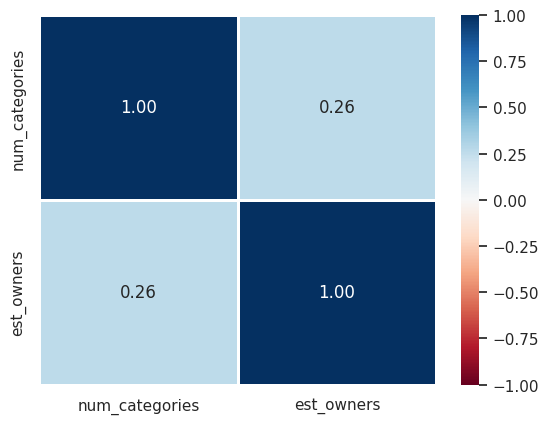

In [36]:
sb.heatmap(kaggle_steam[['num_categories', 'est_owners']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

### `genres`

We also created a `num_genres` column.

In [37]:
kaggle_steam['num_genres'] = kaggle_steam['genres'].str.split(';').map(len)
kaggle_steam['num_genres']

0        1
1        1
2        1
3        1
4        1
        ..
27070    3
27071    3
27072    3
27073    3
27074    3
Name: num_genres, Length: 27075, dtype: int64

In [38]:
genres_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
describe_categorical_as_onehot(genres_df, kaggle_steam['genres'], keep='all')

Column `genres` has 29 unique labels


array(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration',
       'Documentary', 'Early Access', 'Education', 'Free to Play',
       'Game Development', 'Gore', 'Indie', 'Massively Multiplayer',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content',
       'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Tutorial', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'], dtype=object)

In [39]:
pd.concat([kaggle_steam, genres_df], axis=1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0


In [40]:
genres_df

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,Education,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
(genres_df.sum() / len(genres_df)).sort_values(ascending=False).head(10)

Indie           0.717304
Action          0.439631
Casual          0.377101
Adventure       0.370526
Strategy        0.193795
Simulation      0.191837
RPG             0.159224
Early Access    0.109104
Free to Play    0.062936
Sports          0.048827
dtype: float64

#### Observations

We see many labels for software instead of games in general like `Accounting`, `Animation & Modelling`, `Audio Production`, `Design & Illustration` etc. It might be possible for the clustering algorithm to identify software applications as a cluster. 

In [42]:
# pearson's correlation does not work for categorical data. only continuous data.
# sb.heatmap(genres_df.corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f', ax=plt.subplots(1,1,figsize=(24,20))[1], square=True)

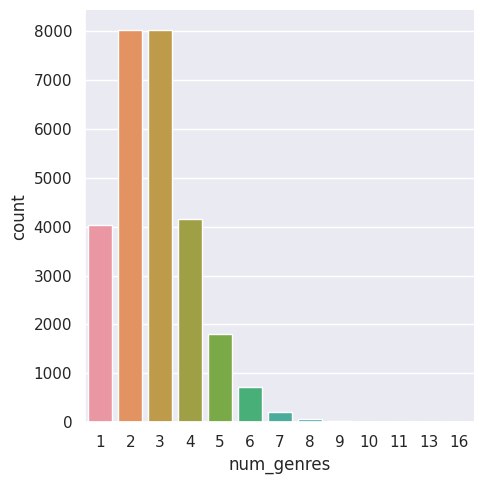

In [43]:
sb.catplot(kaggle_steam, x='num_genres', kind='count')

In [44]:
kaggle_steam['num_genres'].describe()

count    27075.000000
mean         2.824081
std          1.333244
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: num_genres, dtype: float64

<Axes: >

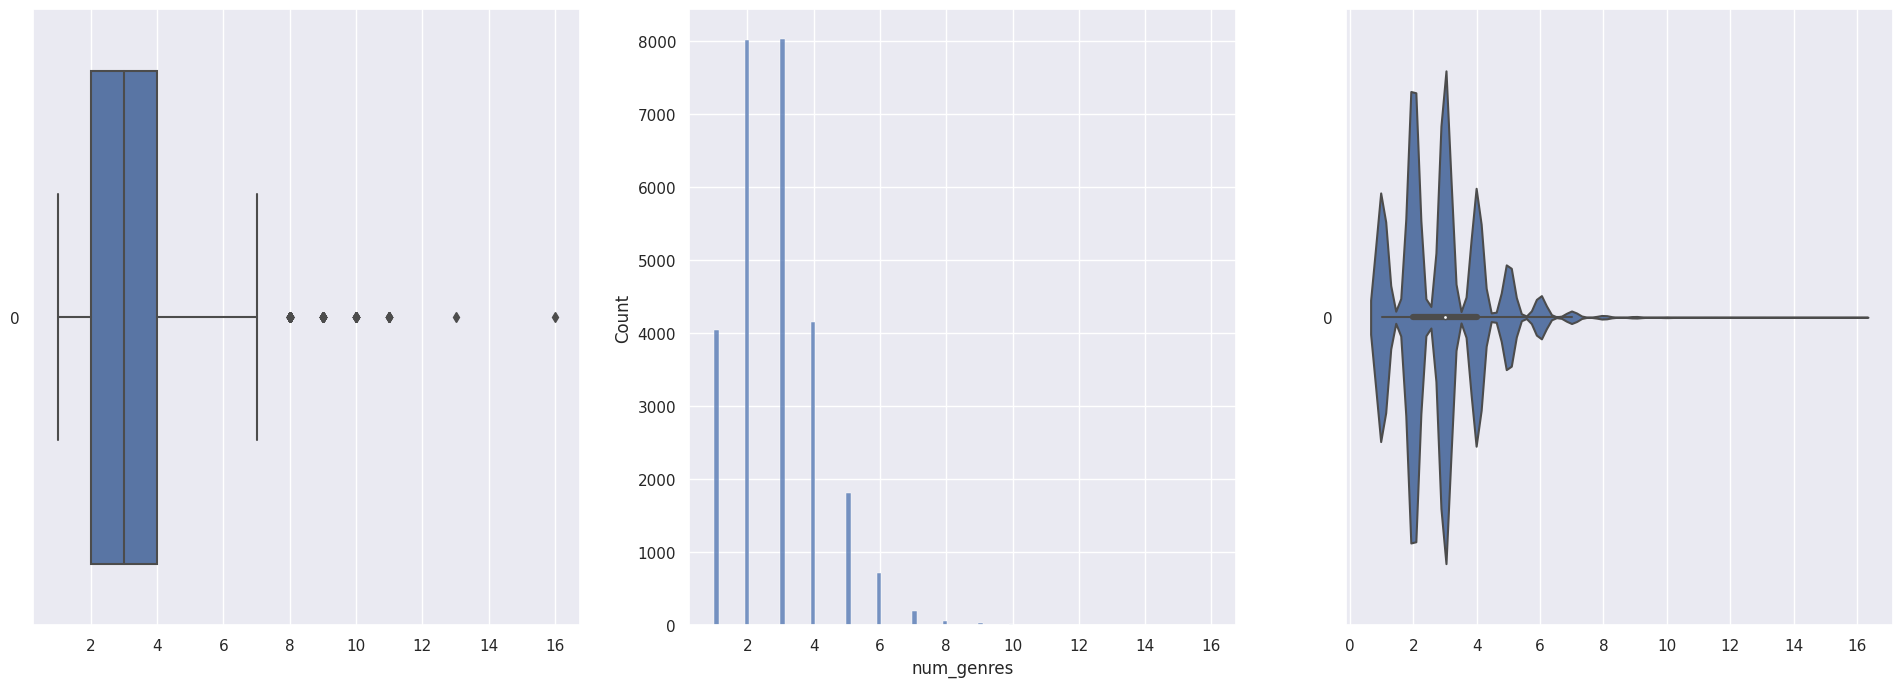

In [45]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
sb.boxplot(data=kaggle_steam['num_genres'], orient='h', ax=ax[0])

sb.histplot(data=kaggle_steam['num_genres'], ax=ax[1])

sb.violinplot(data=kaggle_steam['num_genres'], orient='h', ax=ax[2])

In [46]:
kaggle_steam[kaggle_steam['num_genres'] > 7]['num_genres'].value_counts()

8     60
9     26
10    12
11     7
13     1
16     1
Name: num_genres, dtype: int64

#### Observations 2

It seems that genres > 10 are filled with games that are somewhat unpopular. Perhaps this is a marketing scheme to make the game show up in more searches and hence increase the likelihood of them being purchased. However, based on our investigation, this proves to be untrue (corr=-0.07). There is also no correlation between `num_categories` and `num_genres`.

In [47]:
kaggle_steam[kaggle_steam['num_genres'] > 10].sort_values(by='est_owners')

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,median_playtime,owners,price,year,est_owners,linux,mac,windows,num_categories,num_genres
16768,697630,WARMA,2018-06-19,1,WARMA Corporation,WARMA Corporation,windows,0,Online Multi-Player;MMO,Nudity;Violent;Gore;Action;Adventure;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,2,11
24494,933920,GIRLS VR UNCENSORED!!!,2018-09-28,1,Eroticon VR,Eroticon VR,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,1,11
24515,934710,英语杀,2018-11-04,0,边玩边学网络科技有限公司,边玩边学网络科技有限公司,windows,0,Single-player,Casual;Free to Play;Indie;RPG;Strategy;Account...,...,0,0-20000,0.00,2018,4.30103,0,0,1,1,16
24524,934990,Cute Girls VR,2018-09-22,1,Tomimar,Tomimar,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,6.19,2018,4.30103,0,0,1,1,11
25010,953610,HOT GIRLS VR,2018-10-26,1,tomimar,tomimar,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,1,11
25118,958300,Cute Girls 可爱的女孩,2018-10-21,1,Dance studio mix,Dance studio mix,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,2.89,2018,4.30103,0,0,1,1,11
25951,994320,Night City 2177,2019-02-23,1,Alongini,Alongini,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,2.89,2019,4.30103,0,0,1,1,11
26957,1050150,Sexy Miss,2019-04-20,1,Sexy Miss Studio,Sexy Miss Studio,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,13.99,2019,4.30103,0,0,1,1,11
20466,803010,Supermedium - Virtual Reality Browser,2018-03-06,1,Supermedium,Supermedium,windows,0,Single-player,Casual;Free to Play;Indie;Accounting;Animation...,...,0,20000-50000,0.00,2018,4.69897,0,0,1,1,13


<Axes: >

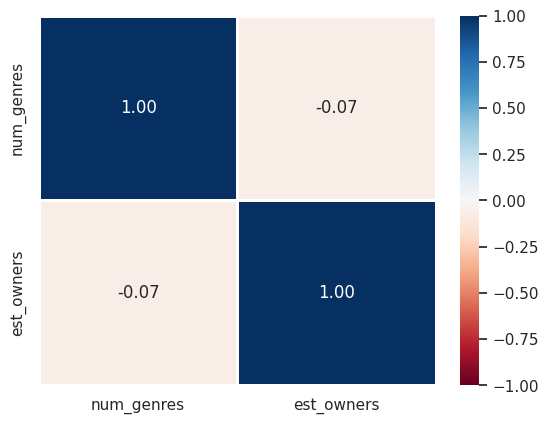

In [48]:
sb.heatmap(kaggle_steam[['num_genres', 'est_owners']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

<Axes: >

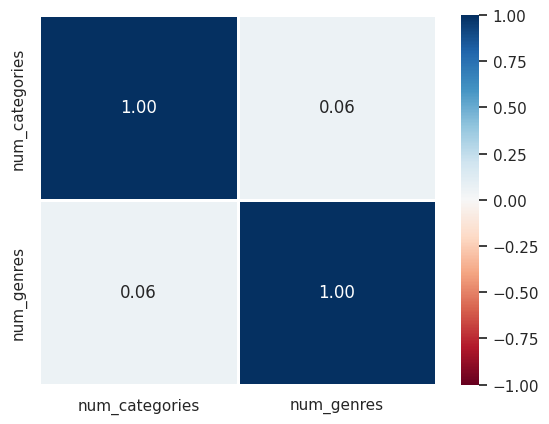

In [49]:
sb.heatmap(kaggle_steam[['num_categories', 'num_genres']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

### `steamspy_tags`

In [50]:
kaggle_steam['num_steamspy_tags'] = kaggle_steam['steamspy_tags'].str.split(';').map(len)
kaggle_steam['num_steamspy_tags']

0        3
1        3
2        3
3        3
4        3
        ..
27070    3
27071    3
27072    3
27073    3
27074    3
Name: num_steamspy_tags, Length: 27075, dtype: int64

In [51]:
import warnings
warnings.filterwarnings('ignore')
tags_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
r = describe_categorical_as_onehot(tags_df, kaggle_steam['steamspy_tags'], keep='all') # this generates a lot of warnings
warnings.filterwarnings('default')
tags_df = tags_df.copy(deep=True)
r

Column `steamspy_tags` has 339 unique labels


array(['1980s', "1990's", '2.5D', '2D', '2D Fighter', '360 Video', '3D',
       '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF',
       'Abstract', 'Action', 'Action RPG', 'Action-Adventure',
       'Adventure', 'Agriculture', 'Aliens', 'Alternate History',
       'America', 'Animation & Modeling', 'Anime', 'Arcade',
       'Arena Shooter', 'Assassin', 'Atmospheric', 'Audio Production',
       'BMX', 'Base-Building', 'Baseball', 'Basketball', 'Batman',
       'Battle Royale', "Beat 'em up", 'Beautiful', 'Benchmark', 'Bikes',
       'Blood', 'Board Game', 'Bowling', 'Building', 'Bullet Hell',
       'Bullet Time', 'CRPG', 'Capitalism', 'Card Game', 'Cartoon',
       'Cartoony', 'Casual', 'Cats', 'Character Action Game',
       'Character Customization', 'Chess', 'Choices Matter',
       'Choose Your Own Adventure', 'Cinematic', 'City Builder',
       'Class-Based', 'Classic', 'Clicker', 'Co-op', 'Cold War',
       'Colorful', 'Comedy', 'Comic Book', 'Competitive', 'Controll

In [52]:
(tags_df.sum() / len(tags_df)).sort_values(ascending=False)

Indie                             0.599520
Action                            0.381237
Casual                            0.303047
Adventure                         0.286981
Strategy                          0.154127
                                    ...   
Investigation                     0.000037
Cinematic                         0.000037
Inventory Management              0.000037
Intentionally Awkward Controls    0.000037
Logic                             0.000037
Length: 339, dtype: float64

#### Observation 1

Most tags are very seldomly used/too specific. 75% of tags are only used by just 55 games. While specific tags can help carve out clusters, if they are only represented by a few games, it could mean that the label itself is not very widely-known/accepted as of yet. It could also just be a synonym for another tag. Hence we should be careful about which labels we decide to include. Since we want to carve out general clusters rather than specific clusters, we can most likely set a threshold to filter less popular tags.

Furthermore, some of these tags appear to be the same labels as genres.

In [53]:
tags_df.sum().describe()

count      339.000000
mean       230.094395
std       1258.224753
min          1.000000
25%          4.000000
50%         14.000000
75%         55.000000
max      16232.000000
dtype: float64

# Summary

- Pearson's correlation coefficient cannot be used for categorical data. (association, chi-squared?)
- PCA cannot be used for categorical data. (MCA, MFA)
- K-means cannot be used for categorical data. (k-modes, k-prototype)

real numeric:
- num_categories
- num_genres
- num_steamspy_tags
- year

pseudo numeric:
- est_owners

Perhaps could try: TargetEncoder
- for platforms
- for categories
- for genre

# KModes

In [54]:
kaggle_steam['Single-player'] = categories_df['Single-player']
kaggle_steam['Multi-player'] = categories_df['Multi-player']
if "Accounting" not in kaggle_steam.columns:
  kaggle_steam = pd.concat([kaggle_steam, genres_df], axis=1)
kaggle_steam.dtypes

appid                      int64
name                      object
release_date              object
english                    int64
developer                 object
publisher                 object
platforms                 object
required_age               int64
categories                object
genres                    object
steamspy_tags             object
achievements               int64
positive_ratings           int64
negative_ratings           int64
average_playtime           int64
median_playtime            int64
owners                    object
price                    float64
year                       int64
est_owners               float64
linux                      int64
mac                        int64
windows                    int64
num_categories             int64
num_genres                 int64
num_steamspy_tags          int64
Single-player              int64
Multi-player               int64
Accounting                 int64
Action                     int64
Adventure 

In [55]:
categorical = ['english', 'linux', 'mac', 'linux', 'Single-player', 'Multi-player'] # + list(genres_df.columns)
numerical = ['required_age', 'achievements', 'positive_ratings', 'negative_ratings',
             'average_playtime', 'median_playtime', 'price',
             'year', 'est_owners', 'num_categories', 'num_genres', 'num_steamspy_tags']
X = pd.DataFrame(data=StandardScaler().fit_transform(kaggle_steam.loc[:, numerical]), columns=numerical)
X = pd.concat([kaggle_steam.loc[:, categorical], X], axis=1)
X

,english,linux,mac,linux,Single-player,Multi-player,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,year,est_owners,num_categories,num_genres,num_steamspy_tags
0,1,1,1,1,0,1,-0.147507,-0.128306,6.505741,0.730006,9.557829,0.072624,0.141186,-7.648808,5.213985,0.306835,-1.368178,0.311447
1,1,1,1,1,0,1,-0.147507,-0.128306,0.122045,0.098480,0.069619,-0.035710,-0.265175,-8.112426,4.636120,0.306835,-1.368178,0.311447
2,1,1,1,1,0,1,-0.147507,-0.128306,0.127206,0.043636,0.020358,-0.047606,-0.265175,-6.257955,4.636120,-0.587702,-1.368178,0.311447
3,1,1,1,1,0,1,-0.147507,-0.128306,0.014348,0.013063,0.059220,0.016120,-0.265175,-7.185190,4.636120,0.306835,-1.368178,0.311447
4,1,1,1,1,1,1,-0.147507,-0.128306,0.223792,0.017964,0.259548,0.114258,-0.265175,-8.112426,4.636120,-0.140433,-1.368178,0.311447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1,0,0,0,1,0,-0.147507,-0.108457,-0.052535,-0.049249,-0.081995,-0.062050,-0.506452,1.159926,-0.544894,-0.587702,0.131950,0.311447
27071,1,0,0,0,1,0,-0.147507,-0.128306,-0.052272,-0.049016,-0.081995,-0.062050,-0.557247,1.159926,-0.544894,-1.034970,0.131950,0.311447
27072,1,0,0,0,1,1,-0.147507,-0.060252,-0.052693,-0.049016,-0.081995,-0.062050,-0.265175,1.159926,-0.544894,1.648640,0.131950,0.311447
27073,1,0,1,0,1,0,-0.147507,-0.128306,-0.052588,-0.049249,-0.081995,-0.062050,-0.112790,1.159926,-0.544894,-0.587702,0.131950,0.311447


In [69]:
from kmodes.kprototypes import KPrototypes
import logging

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  model.fit_predict(X=X, y=kaggle_steam.loc[:, 'appid'], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model


In [70]:
cost = [cluster(i).cost_ for i in range(1, 41)]
cost

[04/02/23 05:21:12] INFO     Performing clustering for n=1                                           ]8;id=825611;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=72747;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:21:20] INFO     cost[1]=337109.00                                                      ]8;id=57075;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=347198;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=2                                           ]8;id=83557;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=575840;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:22:14] INFO     cost[2]=303559.65                                                      ]8;id=430565;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=383717;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=3                                           ]8;id=806258;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=174346;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:24:00] INFO     cost[3]=276764.66                                                      ]8;id=259017;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=339343;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=4                                           ]8;id=132199;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=473552;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:26:03] INFO     cost[4]=239896.91                                                      ]8;id=869024;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=438675;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=5                                           ]8;id=293759;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=725671;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:27:57] INFO     cost[5]=215931.95                                                      ]8;id=557974;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=485704;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=6                                           ]8;id=434632;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=113169;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:30:22] INFO     cost[6]=202956.78                                                      ]8;id=733002;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=798754;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=7                                           ]8;id=799036;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=964732;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:32:35] INFO     cost[7]=178366.45                                                      ]8;id=872639;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=333384;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=8                                           ]8;id=47825;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=847889;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:36:00] INFO     cost[8]=146925.52                                                      ]8;id=290555;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=689833;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=9                                           ]8;id=241174;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=247990;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:40:36] INFO     cost[9]=139109.02                                                      ]8;id=300408;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=87799;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=10                                          ]8;id=617747;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=101669;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

[04/02/23 05:43:54] INFO     cost[10]=132528.68                                                     ]8;id=538448;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=419676;file:///tmp/ipykernel_27427/481419406.py#11\11]8;;\

                    INFO     Performing clustering for n=11                                          ]8;id=691576;file:///tmp/ipykernel_27427/481419406.py\481419406.py]8;;\:]8;id=723334;file:///tmp/ipykernel_27427/481419406.py#9\9]8;;\

In [ ]:
cost

In [ ]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 41), 'Cost':cost})
sb.relplot(data=df_cost, x='Cluster', y='Cost', markers=True, kind='line', aspect=1.5)